# YOLOv26 MASK-NOMASK OBJECT DETECTION TRAINING

This snipped of codes are adapted from YOLO documentation. You may check the detail by this link: 
https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolo11-object-detection-on-custom-dataset.ipynb

In [ ]:
# Current Directory
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
# Library datasets and visual tools installation
!uv pip install ultralytics
!pip install roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.4.12 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.9/112.6 GB disk)


This datasets and annotations were taken from **Kaggle - Face Mask Detection (https://www.kaggle.com/datasets/andrewmvd/face-mask-detection)**. 

The original XML format annotations were converted followed by data augmentation with this configuration;  image multiplied three times for training datasets, applying horizontal flip, and added 0.05% noise. No image resizing was performed in order to preserve the original scale.

The original dataset consists of three classes: *face_incorrectmask* (0), *face_mask* (1), and *face_nomask* (2). For this experiment, an additional label, *mask* (3), was introduced for later use. Consequently, the *face_incorrectmask* class was merged later into the *face_mask* category.

In [ ]:
# Import Datasets
!mkdir {HOME}/maskclassification
%cd {HOME}/maskclassification



from roboflow import Roboflow
rf = Roboflow(api_key="o1qohGkkoRNbFNSkLjXh")
project = rf.workspace("ihsanroboflownew").project("face-mask-detection-13ygd")
version = project.version(4) # generate version 4
dataset = version.download("yolo26")




/content/maskclassification
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to face-mask-detection-4 in yolo26:: 100%|██████████| 4074/4074 [00:00<00:00, 10396.41it/s]


Modifying every class labels

In [4]:
import os

BASE_DIR = "face-mask-detection-4"
SPLITS = ["train", "valid", "test"]

# mapping: old_id -> new_id
ID_MAP = {
    "0": "0",  # face_incorrectmask -> face_mask
    "1": "0",  # face_mask -> face_mask
    "2": "1",  # face_nomask -> face_nomask
    "3": "2",  # mask -> mask
}

total_changed = 0

for split in SPLITS:
    label_dir = os.path.join(BASE_DIR, split, "labels")

    for file in os.listdir(label_dir):
        if not file.endswith(".txt"):
            continue

        path = os.path.join(label_dir, file)

        with open(path, "r") as f:
            lines = f.readlines()

        new_lines = []
        changed = False

        for line in lines:
            parts = line.strip().split()
            if not parts:
                continue

            old_id = parts[0]
            if old_id in ID_MAP:
                new_id = ID_MAP[old_id]
                if new_id != old_id:
                    parts[0] = new_id
                    changed = True

            new_lines.append(" ".join(parts))

        if changed:
            total_changed += 1
            with open(path, "w") as f:
                f.write("\n".join(new_lines) + "\n")

print(f"Total changed files: {total_changed}")


Total changed files: 2007


Creating new datasets folder

In [5]:
import os

BASE_DIR = "face_mask_classification"
SPLITS = ["train", "valid", "test"]
SUBFOLDERS = ["images", "labels"]

os.makedirs(BASE_DIR, exist_ok=True)

for split in SPLITS:
    split_dir = os.path.join(BASE_DIR, split)
    os.makedirs(split_dir, exist_ok=True)

    for sub in SUBFOLDERS:
        os.makedirs(os.path.join(split_dir, sub), exist_ok=True)

print("Folder structure created:")
for split in SPLITS:
    for sub in SUBFOLDERS:
        print(f"- {BASE_DIR}/{split}/{sub}")


Folder structure created:
- face_mask_classification/train/images
- face_mask_classification/train/labels
- face_mask_classification/valid/images
- face_mask_classification/valid/labels
- face_mask_classification/test/images
- face_mask_classification/test/labels


Each image was cropped using the bounding box coordinates of *face_mask* and *face_nomask*, and the resulting face regions were stored in a separate folder each category splits (train, valid, test).

All *face_nomask* samples were copied directly into the new dataset. For *face_mask*, only cropped samples containing *mask* annotations were selected in order to balance the dataset, as *face_mask* instances were over-represented. This approach also reduced the annotation effort while retaining meaningful training data. The *face_nomask* data was used as nulls sample.


In [ ]:
# Crop face_masked samples containing mask annotations
import os
import cv2


SRC_BASE = "face-mask-detection-4"
DST_BASE = "face_mask_classification"

SPLITS = ["train", "valid", "test"]

FACE_MASK_ID = 0   # face
MASK_ID = 2        # mask inside face

IMG_SIZE = 320

def yolo_to_xyxy(xc, yc, w, h, img_w, img_h):
    x1 = int((xc - w / 2) * img_w)
    y1 = int((yc - h / 2) * img_h)
    x2 = int((xc + w / 2) * img_w)
    y2 = int((yc + h / 2) * img_h)
    return x1, y1, x2, y2

def xyxy_to_yolo(x1, y1, x2, y2, img_w, img_h):
    xc = ((x1 + x2) / 2) / img_w
    yc = ((y1 + y2) / 2) / img_h
    w = (x2 - x1) / img_w
    h = (y2 - y1) / img_h
    return xc, yc, w, h

# Augmentation stretch to 320px 
def stretch_force(img, size=320):
    h, w = img.shape[:2]
    resized = cv2.resize(img, (size, size))
    sx = size / w
    sy = size / h
    return resized, sx, sy


for split in SPLITS:
    print(f"Processing {split}...")

    img_dir = os.path.join(SRC_BASE, split, "images")
    lbl_dir = os.path.join(SRC_BASE, split, "labels")

    out_img_dir = os.path.join(DST_BASE, split, "images")
    out_lbl_dir = os.path.join(DST_BASE, split, "labels")

    os.makedirs(out_img_dir, exist_ok=True)
    os.makedirs(out_lbl_dir, exist_ok=True)

    for img_name in os.listdir(img_dir):
        if not img_name.lower().endswith((".jpg", ".png", ".jpeg")):
            continue

        img_path = os.path.join(img_dir, img_name)
        lbl_path = os.path.join(
            lbl_dir,
            os.path.splitext(img_name)[0] + ".txt"
        )

        if not os.path.exists(lbl_path):
            continue

        img = cv2.imread(img_path)
        if img is None:
            continue

        h_img, w_img = img.shape[:2]

        with open(lbl_path) as f:
            anns = [l.strip().split() for l in f if l.strip()]

        face_boxes = []
        mask_boxes = []

        for a in anns:
            cid = int(a[0])
            xc, yc, w, h = map(float, a[1:])

            x1, y1, x2, y2 = yolo_to_xyxy(
                xc, yc, w, h, w_img, h_img
            )


            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(w_img, x2)
            y2 = min(h_img, y2)

            if cid == FACE_MASK_ID:
                face_boxes.append((x1, y1, x2, y2))
            elif cid == MASK_ID:
                mask_boxes.append((x1, y1, x2, y2))

        crop_count = 0

        for fx1, fy1, fx2, fy2 in face_boxes:
            contained_masks = []

            for mx1, my1, mx2, my2 in mask_boxes:
                if mx1 >= fx1 and my1 >= fy1 and mx2 <= fx2 and my2 <= fy2:
                    contained_masks.append((mx1, my1, mx2, my2))

            if not contained_masks:
                continue

            face_crop = img[fy1:fy2, fx1:fx2] # Crop code
            if face_crop.size == 0:
                continue

            fc_h, fc_w = face_crop.shape[:2]

            stretched, sx, sy = stretch_force(face_crop, IMG_SIZE)

            crop_count += 1
            crop_name = f"{os.path.splitext(img_name)[0]}_crop{crop_count:03d}"

            cv2.imwrite(os.path.join(out_img_dir, crop_name + ".jpg"),stretched)

            new_labels = []

            for mx1, my1, mx2, my2 in contained_masks:
                rx1 = mx1 - fx1 # Convert mask bbox coordinates into original scale
                ry1 = my1 - fy1
                rx2 = mx2 - fx1
                ry2 = my2 - fy1

                sx1 = int(rx1 * sx)
                sy1 = int(ry1 * sy)
                sx2 = int(rx2 * sx)
                sy2 = int(ry2 * sy)

                xc, yc, w, h = xyxy_to_yolo(sx1, sy1, sx2, sy2,IMG_SIZE, IMG_SIZE)

                new_labels.append(f"0 {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}")

            with open(os.path.join(out_lbl_dir, crop_name + ".txt"), "w") as f:
                f.write("\n".join(new_labels))


Processing train...
Processing valid...
Processing test...


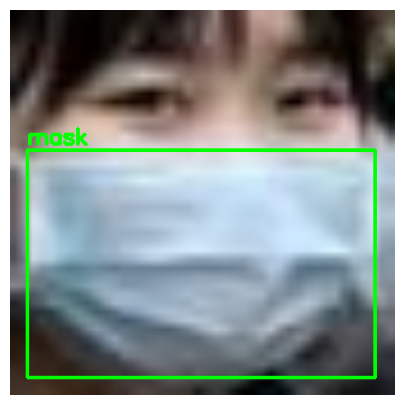

In [ ]:
# Preview face_mask crop that being stretch and validate new align mask bounding box coordinates
import cv2
import matplotlib.pyplot as plt

# PATH
img_path = "/content/maskclassification/face_mask_classification/test/images/maksssksksss104_png.rf.5d715567c8256d02f02e66baab7c8f84_crop001.jpg"
lbl_path = "/content/maskclassification/face_mask_classification/test/labels/maksssksksss104_png.rf.5d715567c8256d02f02e66baab7c8f84_crop001.txt"

# LOAD IMAGE
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

h, w = img.shape[:2]

# LOAD LABEL
with open(lbl_path) as f:
    lines = [l.strip().split() for l in f if l.strip()]

# DRAW BBOX
for l in lines:
    cls, xc, yc, bw, bh = map(float, l)

    x1 = int((xc - bw / 2) * w)
    y1 = int((yc - bh / 2) * h)
    x2 = int((xc + bw / 2) * w)
    y2 = int((yc + bh / 2) * h)

    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(
        img,
        f"mask",
        (x1, max(y1 - 5, 0)),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        (0, 255, 0),
        2
    )

# SHOW
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.axis("off")
plt.show()


In [ ]:
# Update new data.yaml into data_new.yaml
import os

BASE_DIR = "face_mask_classification"
YAML_PATH = os.path.join(BASE_DIR, "data_new.yaml")

yaml_content = f"""train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['mask']
"""

with open(YAML_PATH, "w") as f:
    f.write(yaml_content)

print("data_new.yaml")


data_new.yaml


In [ ]:
# Copying every null (no-mask) annotations and crop based on face_nomask region
import os
import cv2


SRC_BASE = "face-mask-detection-4"
DST_BASE = "face_mask_classification"

SPLITS = ["train", "valid", "test"]

FACE_NOMASK_ID = 1
IMG_SIZE = 320


def yolo_to_xyxy(xc, yc, w, h, img_w, img_h):
    x1 = int((xc - w / 2) * img_w)
    y1 = int((yc - h / 2) * img_h)
    x2 = int((xc + w / 2) * img_w)
    y2 = int((yc + h / 2) * img_h)
    return x1, y1, x2, y2

def stretch_force(img, size=320):
    return cv2.resize(img, (size, size))


for split in SPLITS:
    print(f"Processing {split} (face_nomask → NULL)...")

    img_dir = os.path.join(SRC_BASE, split, "images")
    lbl_dir = os.path.join(SRC_BASE, split, "labels")

    out_img_dir = os.path.join(DST_BASE, split, "images")
    os.makedirs(out_img_dir, exist_ok=True)

    for img_name in os.listdir(img_dir):
        if not img_name.lower().endswith((".jpg", ".png", ".jpeg")):
            continue

        img_path = os.path.join(img_dir, img_name)
        lbl_path = os.path.join(lbl_dir,os.path.splitext(img_name)[0] + ".txt")

        if not os.path.exists(lbl_path):
            continue

        img = cv2.imread(img_path)
        if img is None:
            continue

        h_img, w_img = img.shape[:2]

        with open(lbl_path) as f:
            anns = [l.strip().split() for l in f if l.strip()]

        face_boxes = []

        for a in anns:
            cid = int(a[0])
            if cid != FACE_NOMASK_ID:
                continue

            xc, yc, w, h = map(float, a[1:])
            x1, y1, x2, y2 = yolo_to_xyxy(
                xc, yc, w, h, w_img, h_img
            )

            # clamp
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(w_img, x2)
            y2 = min(h_img, y2)

            face_boxes.append((x1, y1, x2, y2))

        crop_count = 0

        for x1, y1, x2, y2 in face_boxes:
            face_crop = img[y1:y2, x1:x2]
            if face_crop.size == 0:
                continue

            stretched = stretch_force(face_crop, IMG_SIZE)

            crop_count += 1
            crop_name = f"{os.path.splitext(img_name)[0]}_nomask{crop_count:03d}.jpg"

            cv2.imwrite(os.path.join(out_img_dir, crop_name),stretched) # save null image

    print(f"Done {split}")


Processing train (face_nomask → NULL)...
Done train
Processing valid (face_nomask → NULL)...
Done valid
Processing test (face_nomask → NULL)...
Done test



=== TRAIN ===
Total images      : 3387
NULL images (no txt): 1317


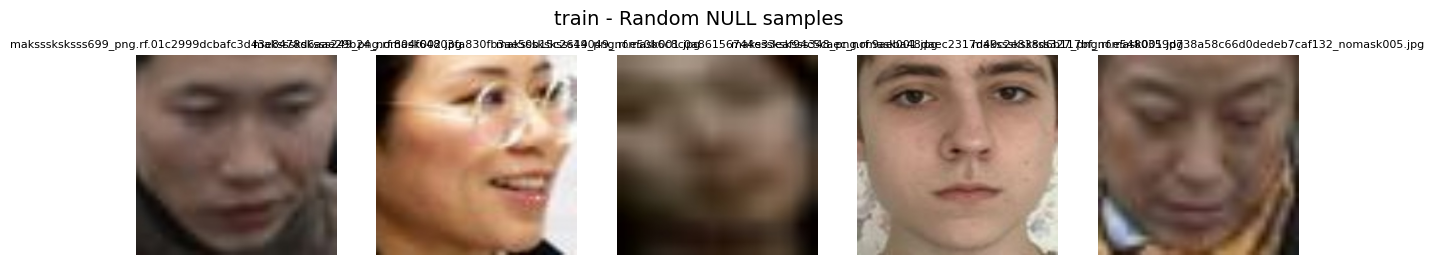


=== VALID ===
Total images      : 392
NULL images (no txt): 184


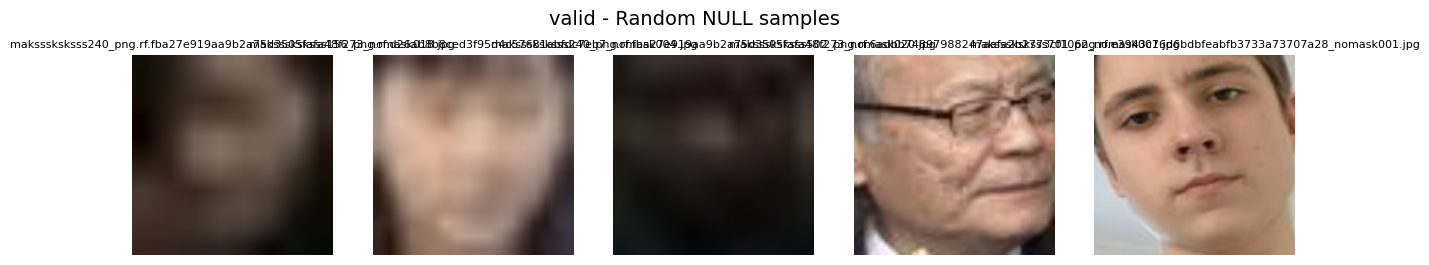


=== TEST ===
Total images      : 173
NULL images (no txt): 79


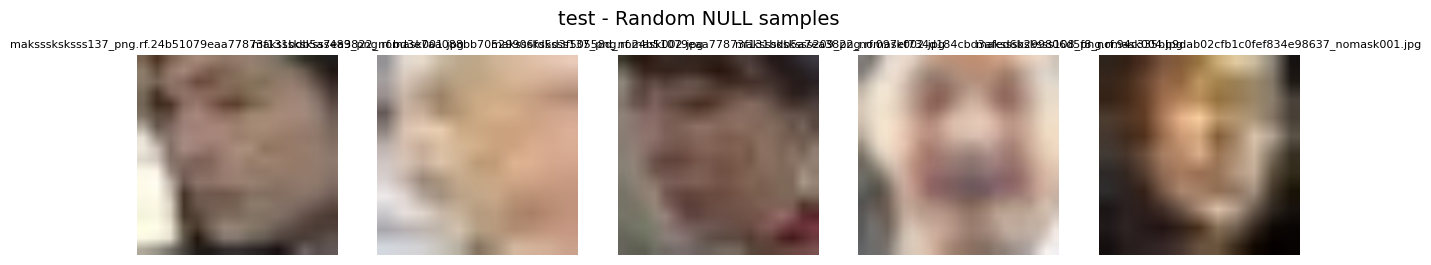

In [ ]:
# Preview null (no-mask) images
import os
import random
import cv2
import matplotlib.pyplot as plt

BASE_DIR = "face_mask_classification"
SPLITS = ["train", "valid", "test"]
SAMPLES_PER_SPLIT = 5

def count_null_images(split):
    img_dir = os.path.join(BASE_DIR, split, "images")
    lbl_dir = os.path.join(BASE_DIR, split, "labels")

    images = [
        f for f in os.listdir(img_dir)
        if f.lower().endswith((".jpg", ".png", ".jpeg"))
    ]

    null_images = []
    for img in images:
        lbl_path = os.path.join(lbl_dir, os.path.splitext(img)[0] + ".txt")
        if not os.path.exists(lbl_path):
            null_images.append(img)

    return images, null_images

for split in SPLITS:
    images, null_images = count_null_images(split)

    print(f"\n=== {split.upper()} ===")
    print(f"Total images      : {len(images)}")
    print(f"NULL images (no txt): {len(null_images)}")

    if len(null_images) == 0:
        print("No NULL images found.")
        continue

    samples = random.sample(null_images, min(SAMPLES_PER_SPLIT, len(null_images)))

    plt.figure(figsize=(15, 3))
    for i, img_name in enumerate(samples):
        img_path = os.path.join(BASE_DIR, split, "images", img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, len(samples), i + 1)
        plt.imshow(img)
        plt.title(img_name, fontsize=8)
        plt.axis("off")

    plt.suptitle(f"{split} - Random NULL samples", fontsize=14)
    plt.show()


# Datasets Distribution

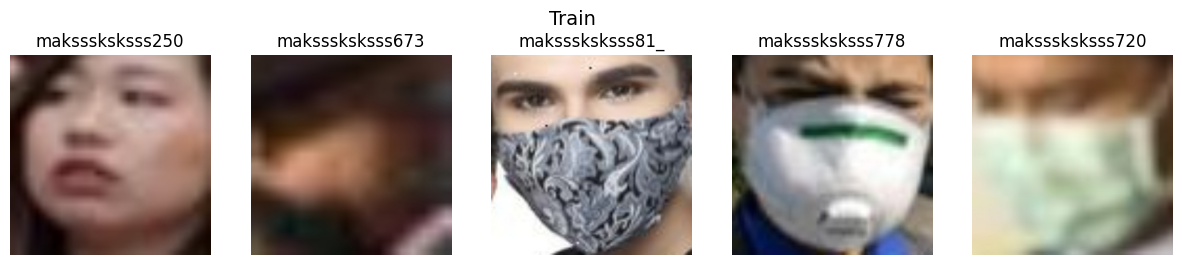

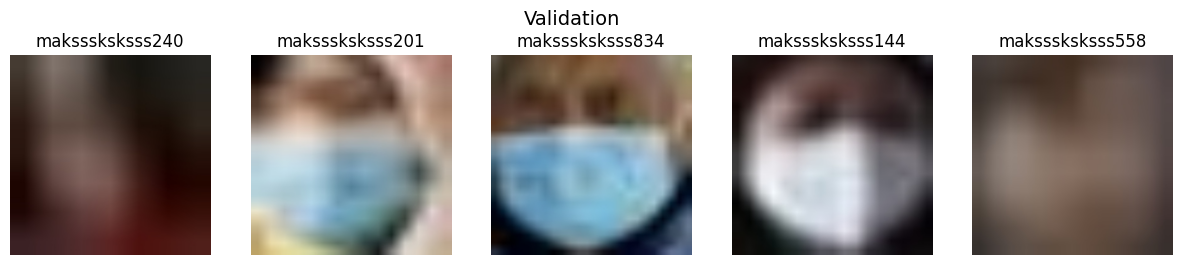

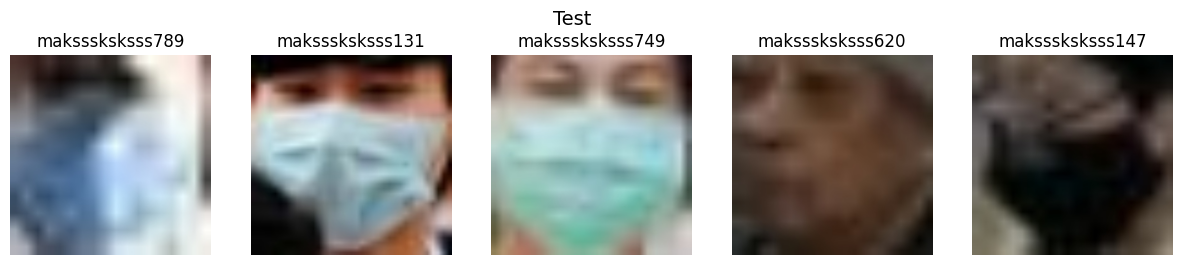

In [14]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

BASE_DIR = "./face_mask_classification"

splits = [
    ("Train", os.path.join(BASE_DIR, "train/images")),
    ("Validation", os.path.join(BASE_DIR, "valid/images")),
    ("Test", os.path.join(BASE_DIR, "test/images")),
]

for split_name, image_dir in splits:
    images = [f for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
    samples = random.sample(images, min(5, len(images)))

    plt.figure(figsize=(15, 3))
    for i, img_name in enumerate(samples):
        img_path = os.path.join(image_dir, img_name)
        img = Image.open(img_path).convert("RGB")

        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(img_name[:15])

    plt.suptitle(split_name, fontsize=14)
    plt.show()


In [15]:
import os

BASE_DIR = "./face_mask_classification"

train_count = len([f for f in os.listdir(f"{BASE_DIR}/train/images") if f.lower().endswith((".jpg", ".png", ".jpeg"))])
val_count   = len([f for f in os.listdir(f"{BASE_DIR}/valid/images") if f.lower().endswith((".jpg", ".png", ".jpeg"))])
test_count  = len([f for f in os.listdir(f"{BASE_DIR}/test/images") if f.lower().endswith((".jpg", ".png", ".jpeg"))])

print("Train:", train_count)
print("Val  :", val_count)
print("Test :", test_count)


Train: 3387
Val  : 392
Test : 173


# Training script

The YOLOv26 nano (n) model was used in this experiment. The model was trained with a 320 × 320 pixel input size to support low-resource mobile edge devices, using the default learning rate for up to 200 epochs with early stopping at 30 epochs. Training was conducted using a single class label: *mask*.


In [18]:
!yolo train model=yolo26n.pt data="/content/maskclassification/face_mask_classification/data_new.yaml" epochs=200 patience=30 imgsz=320 plots=True

Ultralytics 8.4.12 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/maskclassification/face_mask_classification/data_new.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo26n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overla

The model completed training with early stop at 92 epochs, achieving a high validation mAP50 of 0.988, while the stricter evaluation metric, mAP50-95 remained at 0.695.


In [19]:
!ls ./runs/detect/train2/weights


best.pt  last.pt


In [20]:
!cp ./runs/detect/train2/weights/best.pt ./maskdetection.pt


In [21]:
!yolo task=detect mode=val model="./maskdetection.pt" data="./face_mask_classification/data_new.yaml" split=test

Ultralytics 8.4.12 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO26n summary (fused): 122 layers, 2,375,031 parameters, 0 gradients, 5.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 409.5±117.6 MB/s, size: 13.1 KB)
val: Scanning /content/maskclassification/face_mask_classification/test/labels... 94 images, 79 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 173/173 3.2Kit/s 0.1s
val: New cache created: /content/maskclassification/face_mask_classification/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 11/11 7.9it/s 1.4s
                   all        173         94      0.979      0.997      0.994       0.72
Speed: 0.8ms preprocess, 2.9ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /content/maskclassification/runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


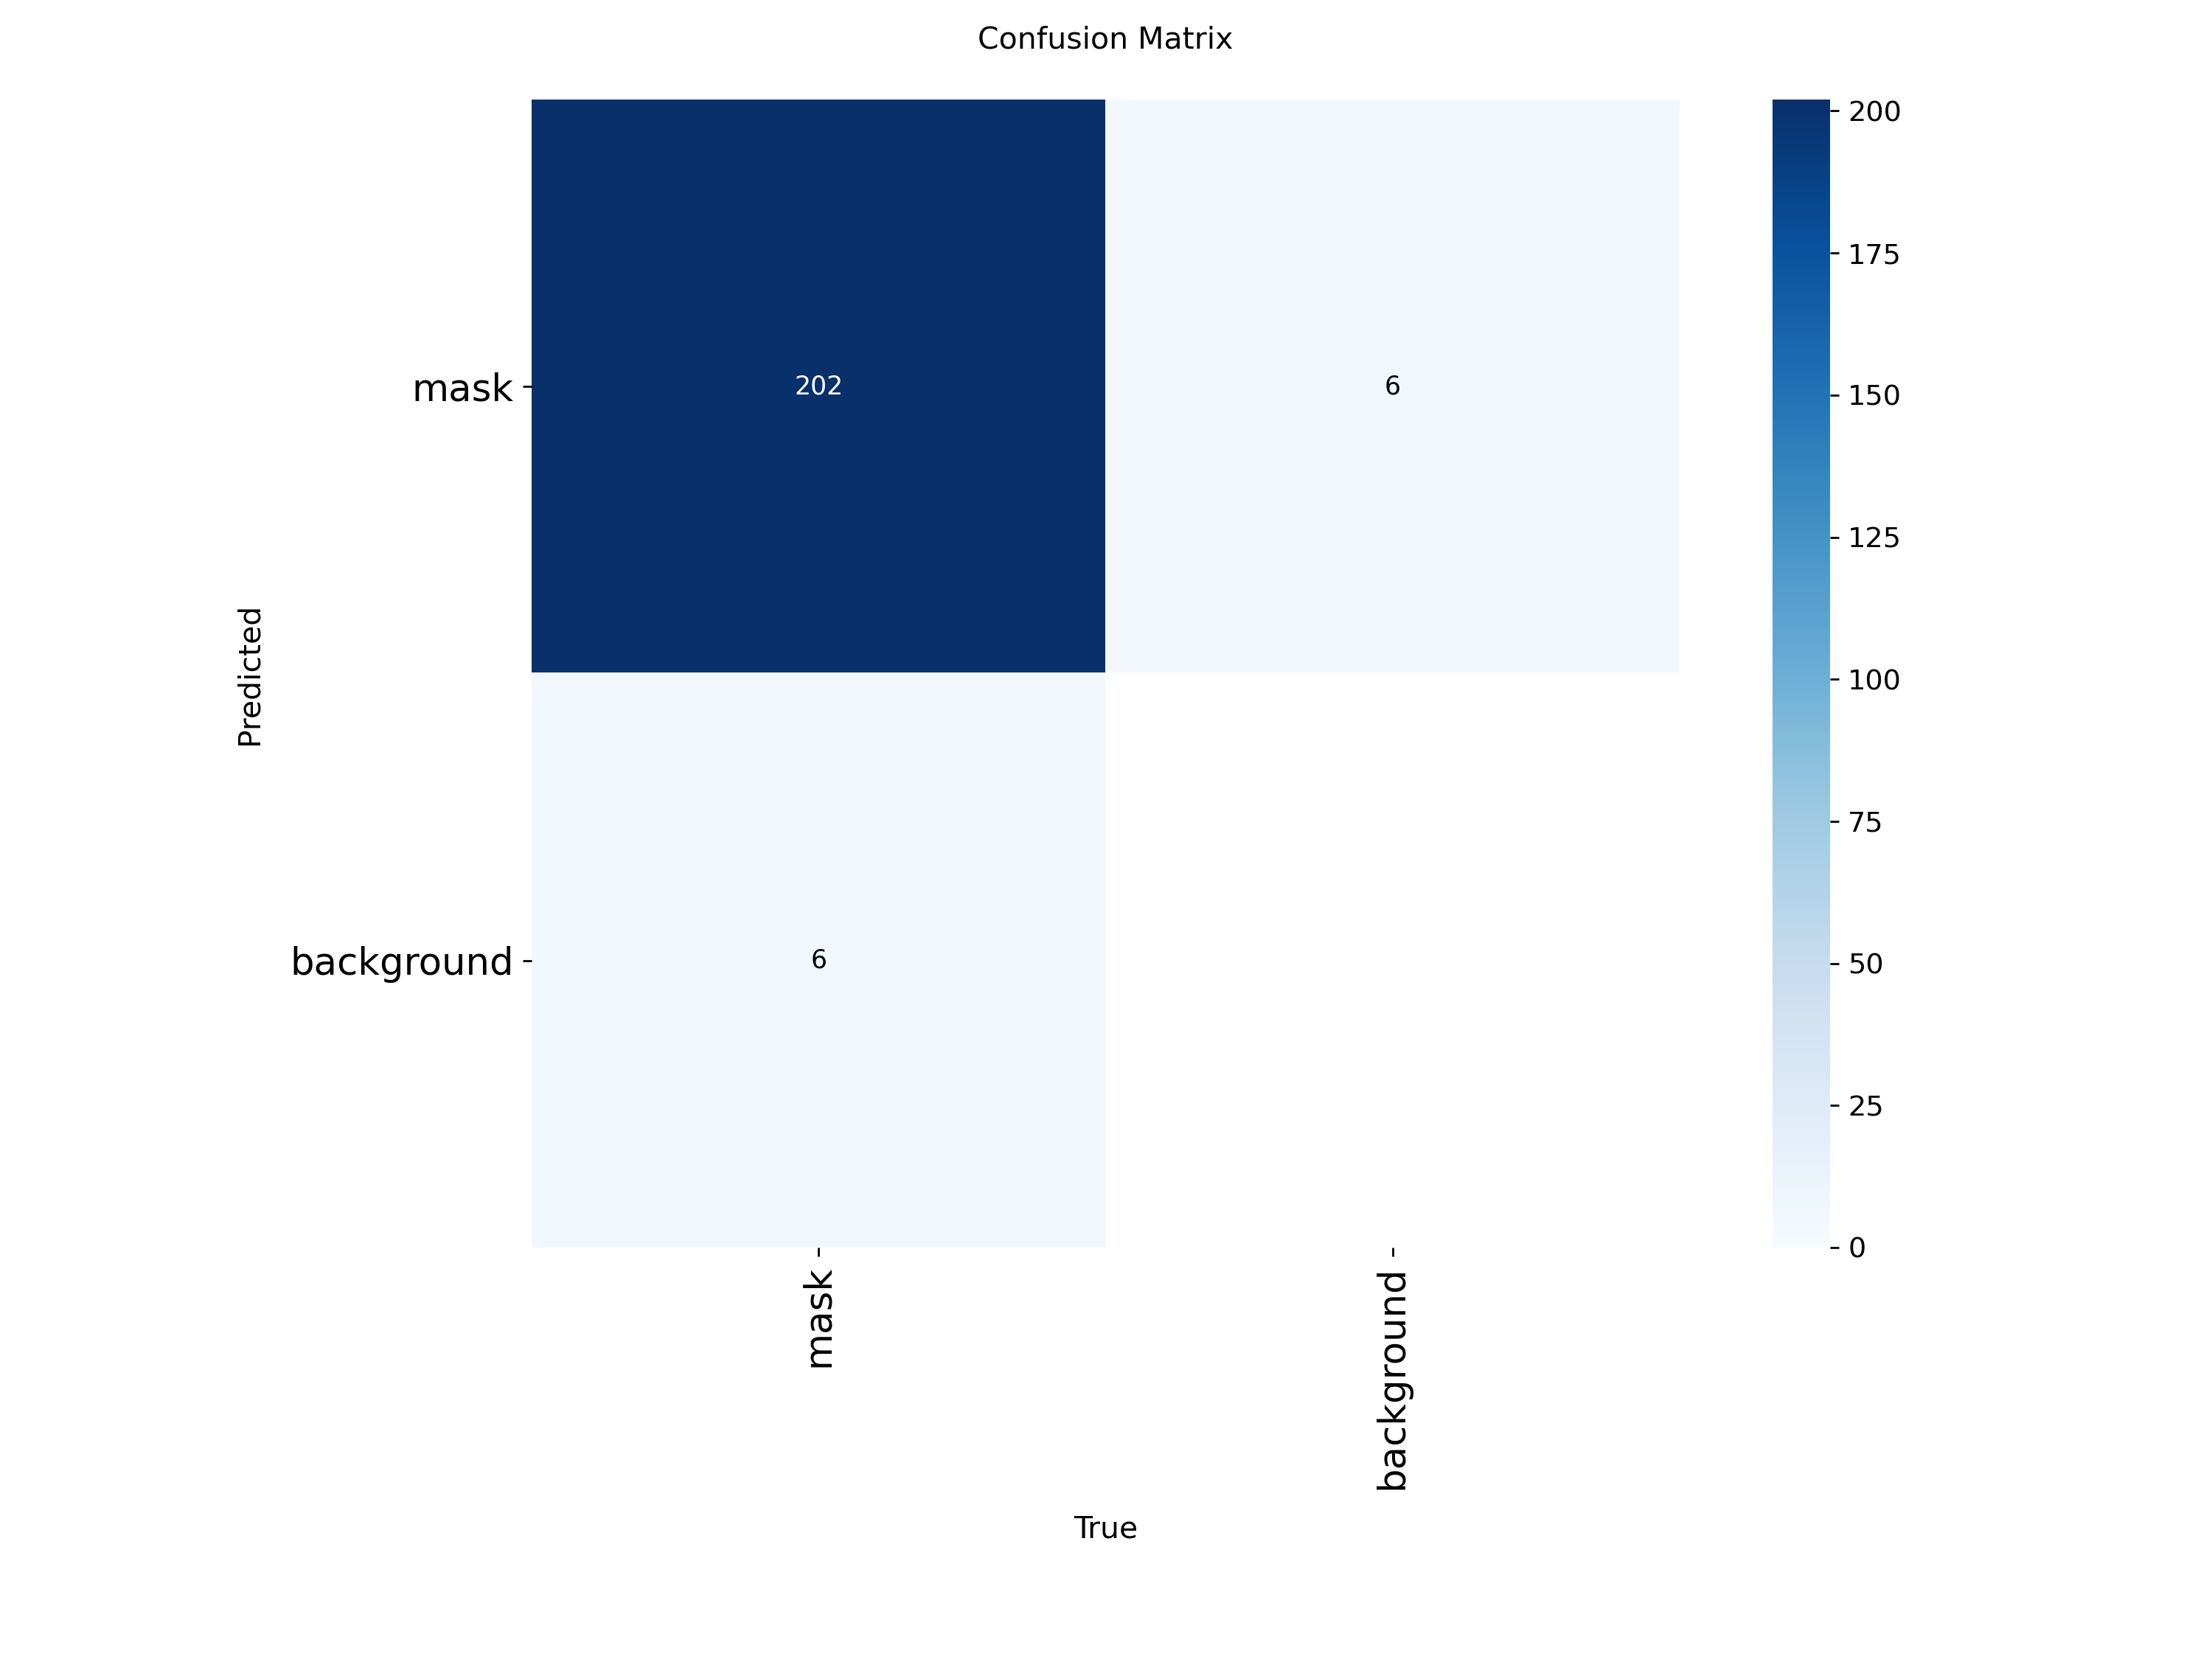

In [23]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'./runs/detect/train2/confusion_matrix.png', width=600)

The confusion matrix above indicates that, using the default confidence threshold of 0.7, the model achieves more than 94% true positive detections. and the rest is misclasified. This giving opportunity for the confidence threshold is increase from medium to high range.

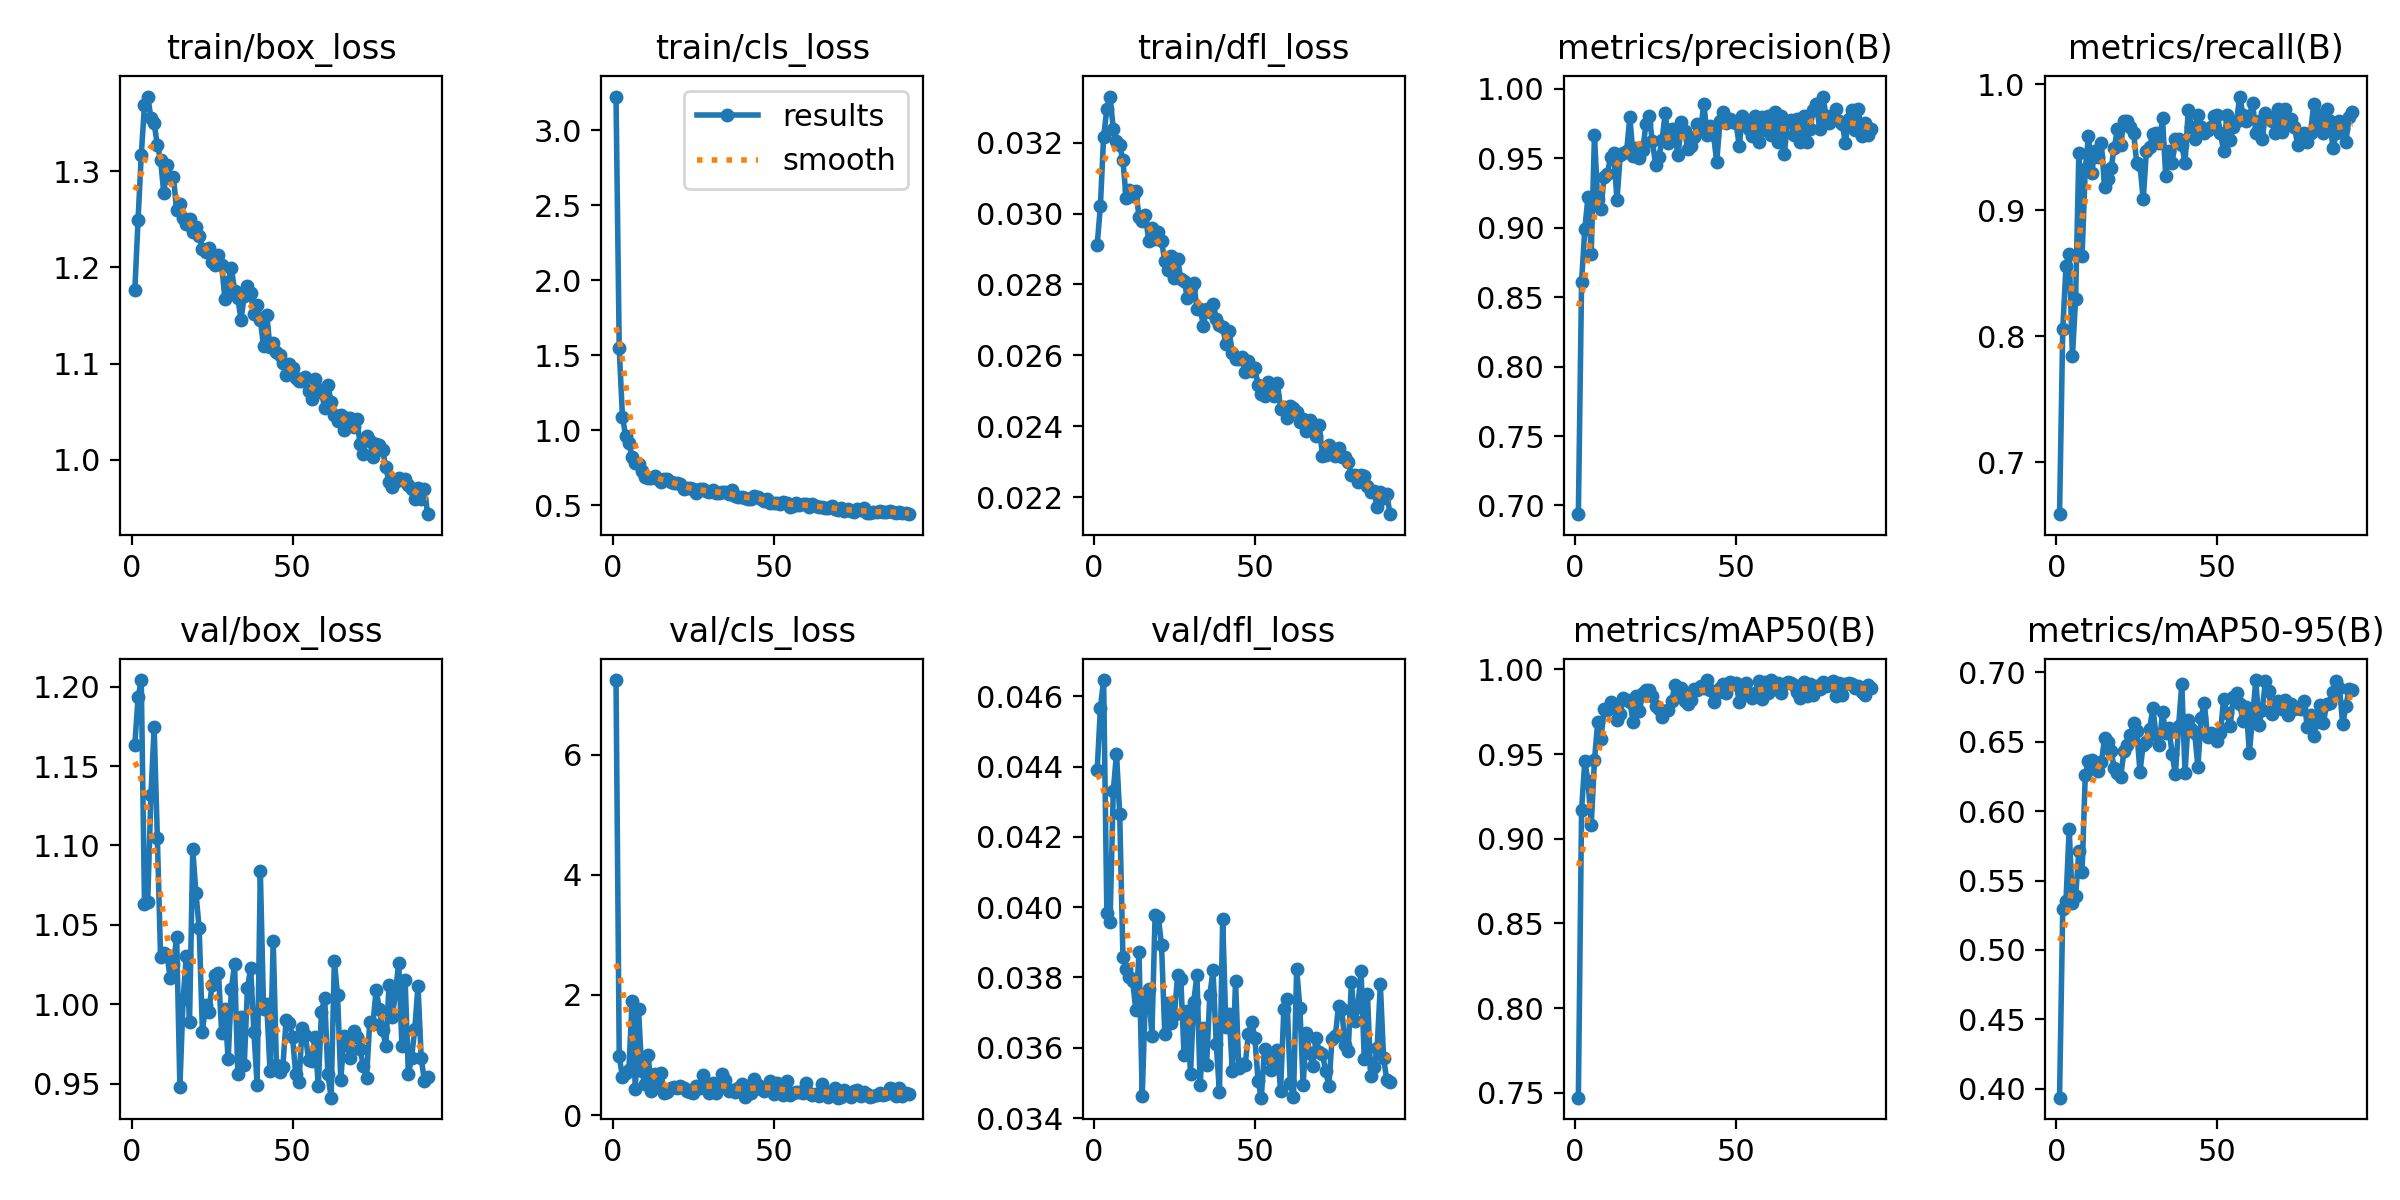

In [24]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'./runs/detect/train2/results.png', width=600)

The training progress plot above shows that the model’s accuracy consistently increases throughout the training process. Although the strict evaluation metric (mAP50–95) indicates that model performance has not yet optimal, both training and validation losses steadily decrease. This trend is consistent with the observed improvements in overall accuracy, reflecting meaningful performance gains during training.


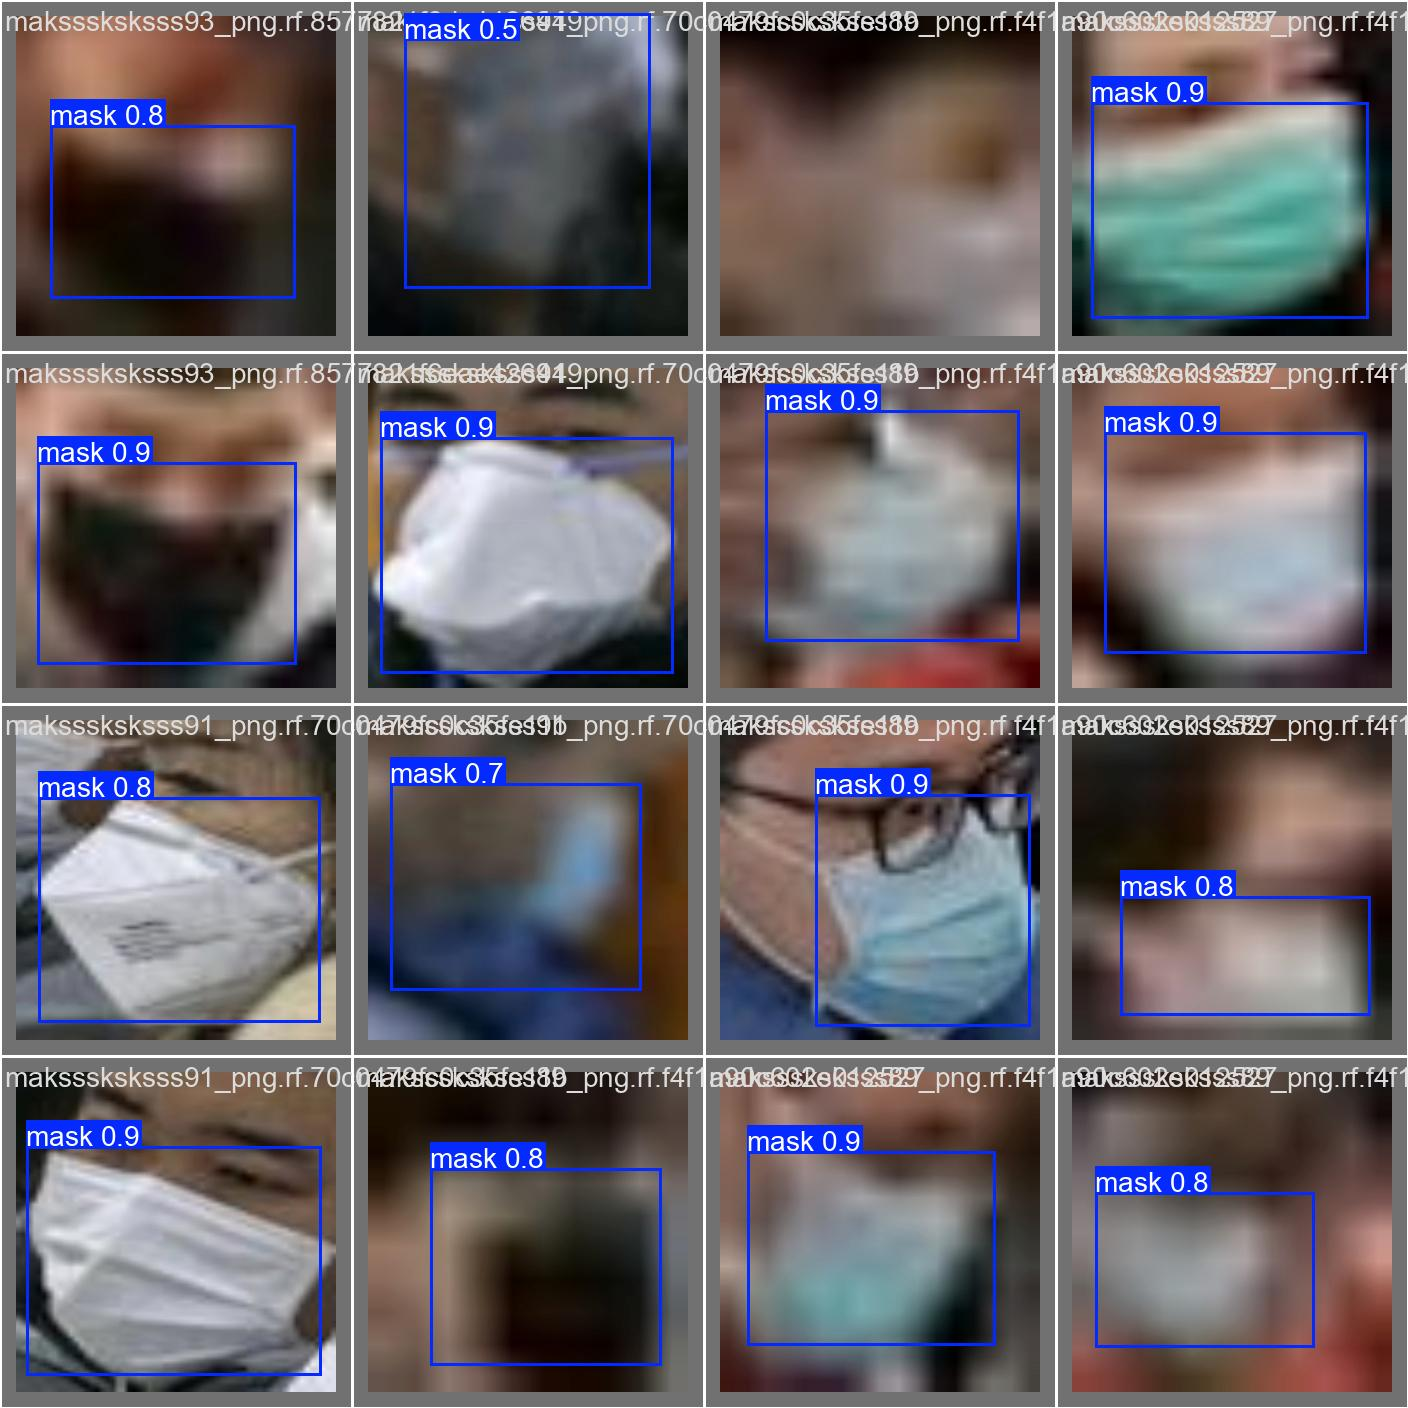

In [25]:
from IPython.display import Image as IPyImage

IPyImage(filename='./runs/detect/train2/val_batch0_pred.jpg', width=600)

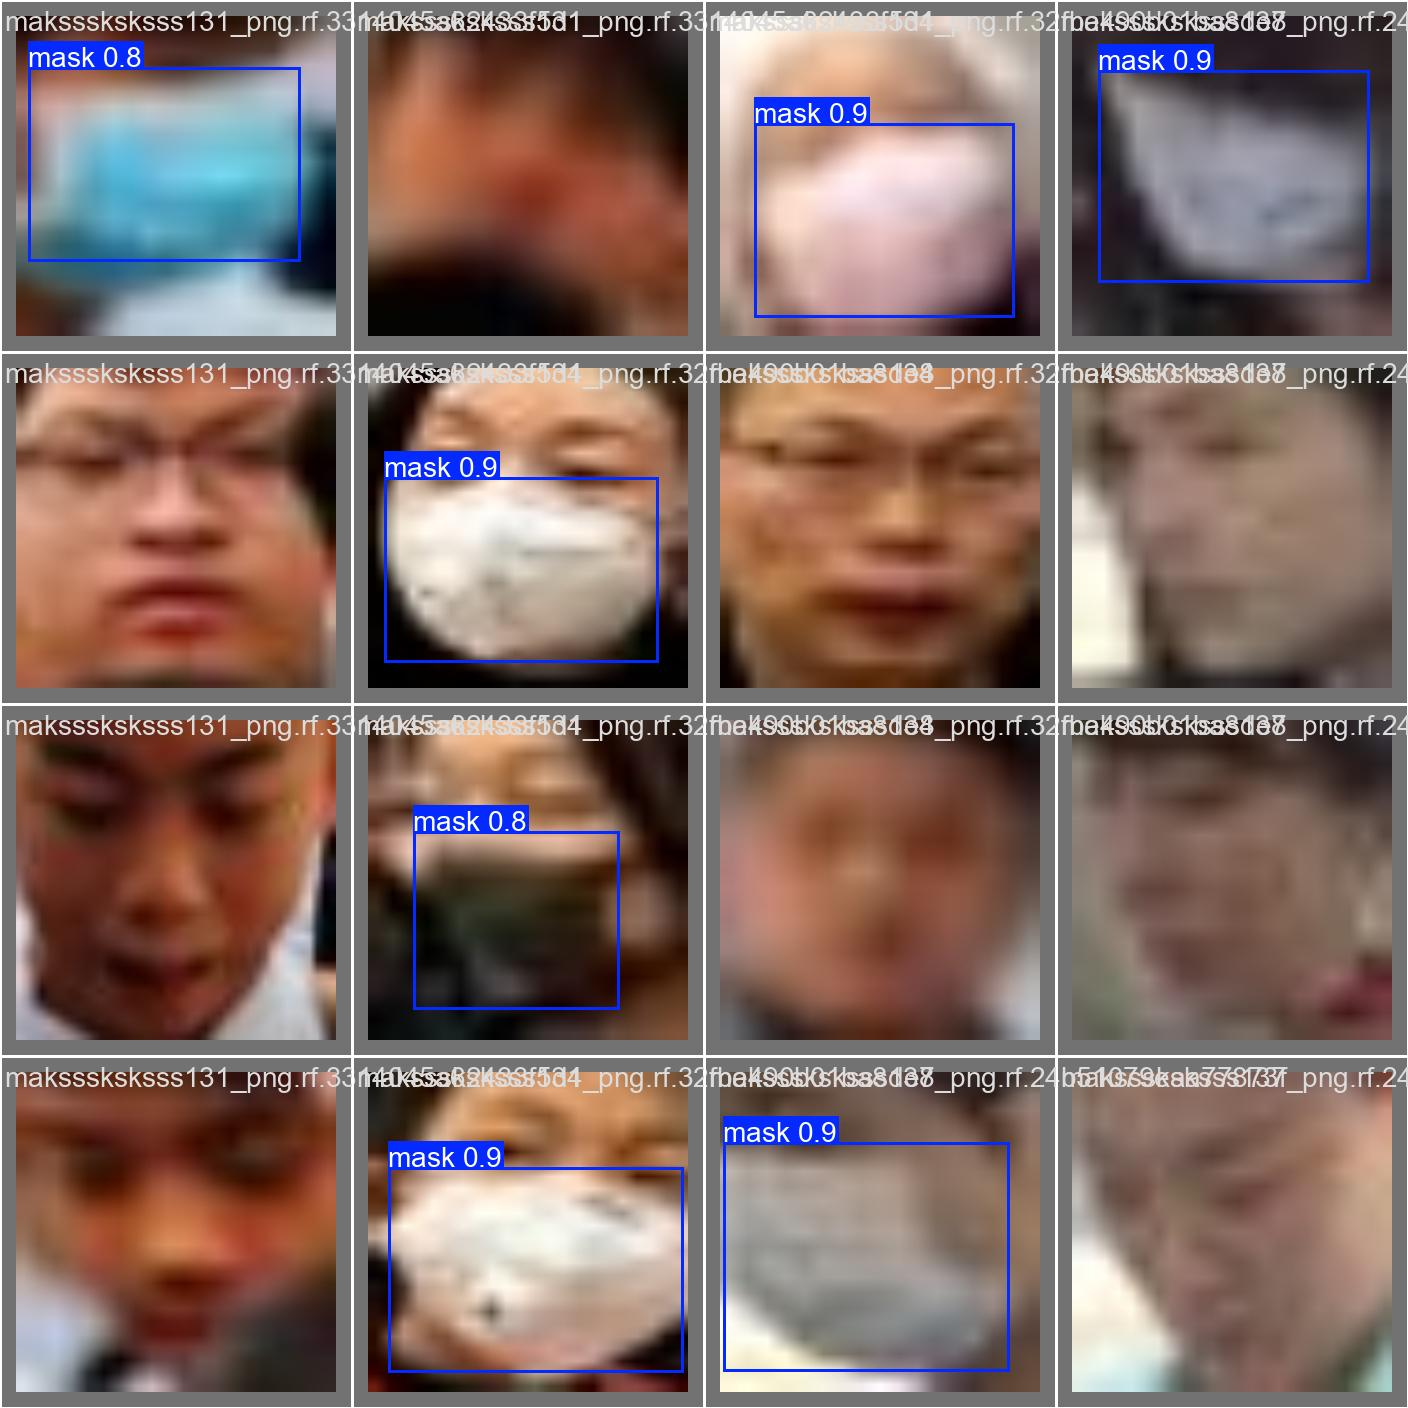

In [26]:
from IPython.display import Image as IPyImage

IPyImage(filename='./runs/detect/val2/val_batch1_pred.jpg', width=600)

In [27]:
!yolo task=detect mode=predict model="./maskdetection.pt" conf=0.7 source="./face_mask_classification/test/images" save=True

Ultralytics 8.4.12 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO26n summary (fused): 122 layers, 2,375,031 parameters, 0 gradients, 5.2 GFLOPs

image 1/173 /content/maskclassification/face_mask_classification/test/images/maksssksksss104_png.rf.5d715567c8256d02f02e66baab7c8f84_crop001.jpg: 320x320 1 mask, 13.6ms
image 2/173 /content/maskclassification/face_mask_classification/test/images/maksssksksss104_png.rf.5d715567c8256d02f02e66baab7c8f84_crop002.jpg: 320x320 1 mask, 9.5ms
image 3/173 /content/maskclassification/face_mask_classification/test/images/maksssksksss104_png.rf.5d715567c8256d02f02e66baab7c8f84_nomask001.jpg: 320x320 (no detections), 9.9ms
image 4/173 /content/maskclassification/face_mask_classification/test/images/maksssksksss104_png.rf.5d715567c8256d02f02e66baab7c8f84_nomask002.jpg: 320x320 (no detections), 8.5ms
image 5/173 /content/maskclassification/face_mask_classification/test/images/maksssksksss104_png.rf.5d715567c8256d02f02e66baab7c8f84_nomask